In [1]:
import matplotlib.pyplot as plt

# Configure matplotlib to use IEEE-style font
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold"
})

# Load basic functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from control import dlqr
from scipy.linalg import block_diag, expm, solve_discrete_are
from numpy.linalg import matrix_power
from cvxopt import matrix, solvers
import polytope as pc
import set_operations as so
import random
from model_uncertainties import load_model
import cvxpy as cp

np.random.seed(50)
random.seed(50)

def BIS(x, C50p):
    Ce, E0 = x[3], 93
    gamma = 1.47 if Ce <= C50p else 1.89 
    bis = E0 * (1 - np.divide(Ce ** gamma, C50p ** gamma + Ce ** gamma))
    return bis

def compute_C50(age):
    C50p = 3.08 * np.exp(-0.00635 * (age - 35))
    return C50p

def inv_BIS(bis, C50p):
    E0 = 93
    gamma = 1.47 if bis >= E0/2 else 1.89
    Ce = (E0/bis - 1)**(1/gamma) * C50p
    return Ce

def dlqr(A, B, Q, R):
    P = solve_discrete_are(A, B, Q, R)
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

def reduced_system(A, B, z_idx, w_idx):
    # Reduced system blocks
    Az, Bz = A[np.ix_(z_idx, z_idx)], B[z_idx, :]
    Aw = A[np.ix_(z_idx, w_idx)]
    return Az, Bz, Aw

def discretize(A, B, ts, method='euler'):
    method = method.lower()
    if method == 'euler':
        nx = A.shape[0]
        Ad = np.eye(nx) + A * ts
        Bd = B * ts
    elif method == 'zoh':
        M = np.block([[A, B], [np.zeros((B.shape[1], A.shape[0] + B.shape[1]))]]) * ts
        M_exp = expm(M)
        Ad = M_exp[:A.shape[0], :A.shape[0]]
        Bd = M_exp[:A.shape[0], A.shape[0]:]
    return Ad, Bd


# Generate random patient and compute constraints

In [3]:
# Generate Patient
patient_char = [27, 180, 80, 1]
age, height, weight, sex = patient_char
A_nom, A_lo, A_hi, A_real, B_nom, B_lo, B_hi, B_real = load_model(patient_char, 'Propofol', 'Schnider', True, 2)

# compute equilibriums
C50p = compute_C50(age)
C40, C50, C60 = inv_BIS(40, C50p), inv_BIS(50, C50p), inv_BIS(60, C50p)

# Compute state bounds
x_min = np.array([C60, 0, 0, C60])
x_max = np.array([10, C50, C50, C40])

# Compute input bounds
ueq = 1/B_nom[0] * (-A_nom[0, 0] - A_nom[0, 1] - A_nom[0, 2]) * C50
u_min, u_max = 0, 6.67

## define the reduced system

In [4]:
# Discretize the system
Ad_nom, Bd_nom = discretize(A_nom, B_nom, ts=1.0, method='zoh')
Ad_lo, Bd_lo = discretize(A_lo, B_lo, ts=1.0, method='zoh')
Ad_hi, Bd_hi = discretize(A_hi, B_hi, ts=1.0, method='zoh')
# Ad_real, Bd_real = discretize(A_real, B_real, ts=1.0, method='zoh')

# Define the reduced system
z_idx = [0, 3]
w_idx = [1, 2]
Ceq = C50
Az, Bz, Aw = reduced_system(Ad_nom, Bd_nom, z_idx, w_idx)
Az_lo, Bz_lo, Aw_lo = reduced_system(Ad_lo, Bd_lo, z_idx, w_idx)
Az_hi, Bz_hi, Aw_hi = reduced_system(Ad_hi, Bd_hi, z_idx, w_idx)

# Define the reduced system bounds
z_min = x_min[z_idx] - Ceq
z_max = x_max[z_idx] - Ceq

xw_min = x_min[w_idx] - Ceq
xw_max = x_max[w_idx] - Ceq
w_min = Aw @ xw_min
w_max = Aw @ xw_max

v_min = u_min - ueq
v_max = u_max - ueq

# Inflate the slow disturbance bounds
Aw_bar = np.maximum(np.abs(Aw_lo - Aw), np.abs(Aw_hi - Aw))
xw_abs = np.maximum(np.abs(xw_min), np.abs(xw_max))
dw = Aw_bar @ xw_abs
w_min -= dw
w_max += dw

# Compute the fast disturbance bounds
Az_bar = np.maximum(np.abs(Az_lo - Az), np.abs(Az_hi - Az))
Bz_bar = np.maximum(np.abs(Bz_lo - Bz), np.abs(Bz_hi - Bz))
z_abs = np.maximum(np.abs(z_min), np.abs(z_max))
v_abs = np.maximum(np.abs(v_min), np.abs(v_max))
d_max = Az_bar @ z_abs + Bz_bar @ v_abs

# Define the polytopes

In [5]:
# Define the CL control law: Acl
Q1 = np.diag([1, 1e2]) # for MRPI
Q2 = np.diag([1, 1e2]) # for mRPI
R = np.diag([2])
K1, P1 = dlqr(Az, Bz, Q1, R)
K2, _ = dlqr(Az, Bz, Q2, R)
Acl1 = Az - Bz @ K1
Acl2 = Az - Bz @ K2

# H-representation of the state constraints
Gz = np.array([[1,  0], [0,  1], [-1,  0], [0, -1]])
gz = np.hstack([z_max, -z_min])
pZ = pc.Polytope(Gz, gz)
pZ = pc.reduce(pZ)

# H-representation of the input constraints
Gv = np.array([[1], [-1]])
gv = np.hstack([v_max, -v_min])
pV = pc.Polytope(Gv, gv)

# Stacking the state, input, and output constraints
Gzv = np.vstack([Gz, Gv @ -K2])
gzv = np.hstack([gz, gv])
pZV = pc.Polytope(Gzv, gzv)
pZV = pc.reduce(pZV)

# H-representation of the slow disturbance constraints
Gw_slow = np.array([[1,  0], [0,  1], [-1,  0], [0, -1]])
gw_slow = np.hstack([w_max, -w_min])
pW_slow = pc.Polytope(Gw_slow, gw_slow)
pW_slow = pc.reduce(pW_slow)

# H-representation of the fast disturbance constraints
Gw_fast = np.array([[1,  0], [0,  1], [-1,  0], [0, -1]])
gw_fast = np.hstack([d_max, d_max])
pW_fast = pc.Polytope(Gw_fast, gw_fast)
pW_fast = pc.reduce(pW_fast)

# Combined disturbance polytope
pW = so.minkowski_sum(pW_slow, pW_fast)

## compute the sets

In [14]:
max_iter = 5000
eps = 1e-7
lam = 0.97

# Compute the minimal robust invariant set
min_RPI = so.compute_min_invariant(Acl2, pW, max_iter=max_iter, eps=eps)
scale=1.05
S_approx = pc.Polytope(min_RPI.A[::], min_RPI.b[::] * scale)
approx_min_RPI = so.compute_max_invariant(S_approx, Acl2, max_iter=max_iter, eps=eps)

# Tighten the state constraints by the minimal RPI set
pZV_robust = so.pontryagin_difference(pZV, min_RPI)

# Compute the maximal PI, RPI, and lambda-RPI sets
max_PI = so.compute_max_invariant(pZV, Acl1, max_iter=max_iter, eps=eps)
max_RPI = so.compute_max_invariant(pZV_robust, Acl1, lam=1, max_iter=max_iter, eps=eps)
max_RPI_lbd = so.compute_max_invariant(pZV_robust, Acl1, lam=lam, max_iter=max_iter, eps=eps)

Computing MPI:   1%|          | 29/5000 [00:00<01:16, 65.08it/s] 


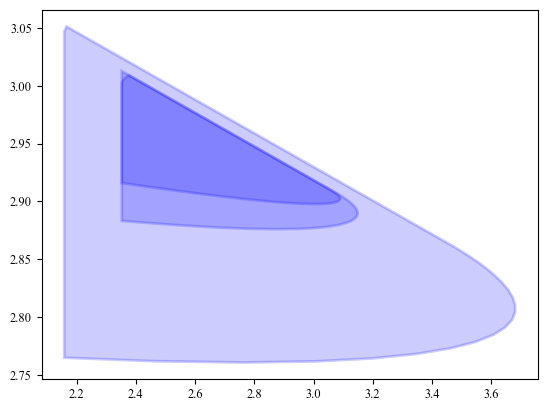

In [15]:
# so.plot_poly(pZV, offset=C50)
so.plot_poly(max_PI, offset=C50)
so.plot_poly(max_RPI, offset=C50)
so.plot_poly(max_RPI_lbd, offset=C50)


# Simulate MPC

In [16]:
import cvxpy as cp
import numpy as np

class TubeMPC:
  
    def __init__(self, Az, Bz, K, pZ, pV, S, omega, N, Q, R, P,
                 solver="MOSEK", verbose=False):

        self.Az = np.asarray(Az)
        self.Bz = np.asarray(Bz)
        self.K = np.asarray(K)
        self.N = int(N)
        self.Q = np.asarray(Q)
        self.R = np.asarray(R)
        self.P = np.asarray(P)
        self.solver = solver
        self.verbose = verbose

        nz, nv = self.Bz.shape
        self.nz, self.nv = nz, nv

        # Tightened constraints
        self.pZ_bar = pc.reduce(so.pontryagin_difference(pZ, S))
        self.pV_bar = pc.reduce(so.pontryagin_difference(pV, so.linear_image(S, -self.K)))
        self.S = S

        # Decision variables
        self.z_nom = cp.Variable((nz, self.N + 1))
        self.v_nom = cp.Variable((nv, self.N))

        # Parameter for initial condition
        self.x0 = cp.Parameter(nz)
        self.z0 = cp.Variable(nz)

        # Build objective/constraints once
        cost = 0
        constr = []

        # Initial condition constraint
        constr += [self.S.A @ (self.x0 - self.z0) <= self.S.b]
        constr += [self.pZ_bar.A @ self.z0 <= self.pZ_bar.b]
        
        constr += [self.z_nom[:, 0] == self.z0]

        for k in range(self.N):
            constr += [self.z_nom[:, k + 1] == self.Az @ self.z_nom[:, k] + self.Bz @ self.v_nom[:, k]]
            constr += [self.pZ_bar.A @ self.z_nom[:, k] <= self.pZ_bar.b]
            constr += [self.pV_bar.A @ self.v_nom[:, k] <= self.pV_bar.b]
            cost += cp.quad_form(self.z_nom[:, k], self.Q) + cp.quad_form(self.v_nom[:, k], self.R)

        constr += [omega.A @ self.z_nom[:, self.N] <= omega.b]
        cost += cp.quad_form(self.z_nom[:, self.N], self.P)

        self.prob = cp.Problem(cp.Minimize(cost), constr)

        # Warm-start cache
        self._last_z = None
        self._last_v = None

    def solve(self, x0_val):
        self.x0_val = np.asarray(x0_val).reshape(self.nz)
        self.x0.value = self.x0_val

        # Warm start if available
        if self._last_z is not None:
            self.z_nom.value = self._last_z
        if self._last_v is not None:
            self.v_nom.value = self._last_v

        # self.prob.solve(solver=self.solver, verbose=self.verbose, warm_start=True)
        self.prob.solve(
            solver=self.solver,
            verbose=self.verbose,
            warm_start=True,
            mosek_params={
                "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,   # primal feas
                "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,   # dual feas
                "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9 # relative gap
            }
        )

        if self.prob.status not in (cp.OPTIMAL, cp.OPTIMAL_INACCURATE):
            raise ValueError(f"MPC optimization failed: {self.prob.status}")

        z_traj = np.array(self.z_nom.value, copy=True)
        v_traj = np.array(self.v_nom.value, copy=True)

        # Cache for warm-start next call
        self._last_z = z_traj
        self._last_v = v_traj

        return z_traj, v_traj

    def onestep(self, x0_val):
        z_traj, v_traj = self.solve(x0_val)

        v0 = v_traj[:, 0].reshape(self.nv)
        z0 = z_traj[:, 0].reshape(self.nz)

        info = {
            "status": self.prob.status,
            "objective": self.prob.value,
            "z_traj": z_traj,
            "v_traj": v_traj,
        }
        return v0, z0, info


hi: enter at 64, final BIS=50.04
lo: enter at 64, final BIS=50.17


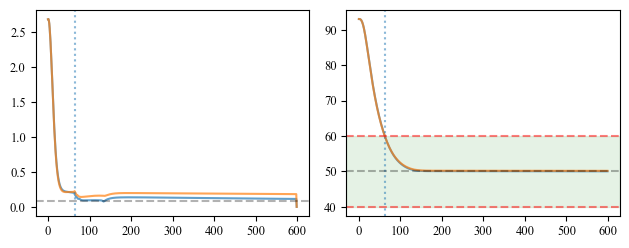

In [18]:
tsim = 600
N = 180
omega = max_RPI_lbd
mpc = TubeMPC(Az, Bz, K2, pZ, pV, approx_min_RPI, omega, N, Q1, R, P1, verbose=False)

Kp, Ti, Td = 0.0622, 333.4439, 34.3669

# Dictionary to store results for each plant model
models = {
    'hi': (Ad_hi, Bd_hi), 
    'lo': (Ad_lo, Bd_lo),
}
model_names = ['hi', 'lo']
results = {}

for model_name, (Ad_model, Bd_model) in models.items():
    
    # Reset PID states for each model
    e_prev = 93 - 50   # initial error
    uI     = 0.0       # integral state
    
    x = np.zeros((4, tsim))
    u = np.zeros((1, tsim))
    y = np.zeros((1, tsim))
    enter = None
    z_nom_list = []
    # enter = 10
    
    for k in range(tsim-1):
        z_k = x[z_idx, k] - Ceq
        y[:, k] = BIS(x[:, k], C50p)

        if so.point_in_set(pZV_robust, z_k):
            v_nom, z_nom, info = mpc.onestep(z_k)
            z_nom_list.append(z_nom)
            u[:, k] = v_nom - K2 @ (z_k - z_nom) + ueq
            if enter is None:
                enter = k
        else:
            e = (y[:, k] - 50).item()
            uP  = Kp * e
            uI += (Kp / Ti) * e                        # backward Euler integral
            uD  = Kp * Td * (e - e_prev)               # backward Euler derivative

            u_k = uP + uI + uD

            # anti-windup: undo integral update if saturated
            if u_k > u_max or u_k < u_min:
                uI -= (Kp / Ti) * e
            
            u[:, k] = u_k
            e_prev = e  # update previous error

        u[:, k] = np.clip(u[:, k], u_min, u_max)
        x[:, k+1] = Ad_model @ x[:, k] + Bd_model @ u[:, k]
    
    y[:, -1] = BIS(x[:, -1], C50p)
    
    results[model_name] = {
        'x': x.copy(),
        'u': u.copy(),
        'y': y.copy(),
        'enter': enter,
        'z_nom': np.array(z_nom_list)
    }
    print(f"{model_name}: enter at {enter}, final BIS={y[:, -1][0]:.2f}")

# Control inputs
plt.subplot(2, 2, 1)
for model_name in model_names:
    u = results[model_name]['u']
    enter = results[model_name]['enter']
    plt.plot(u[0, :], alpha=0.7)
    plt.axvline(enter, linestyle=':', alpha=0.3)
plt.axhline(ueq, linestyle='--', color='k', alpha=0.3)

# BIS
plt.subplot(2, 2, 2)
plt.axhspan(40, 60, color='green', alpha=0.1)
for model_name in model_names:
    y = results[model_name]['y']
    enter = results[model_name]['enter']
    plt.plot(y[0, :], alpha=0.7)
    plt.axvline(enter, linestyle=':', alpha=0.3)
plt.axhline(40, color='red', linestyle='--', alpha=0.5)
plt.axhline(60, color='red', linestyle='--', alpha=0.5)
plt.axhline(50, linestyle='--', color='k', alpha=0.3)

plt.tight_layout()
plt.savefig('input_output.pdf', bbox_inches='tight')

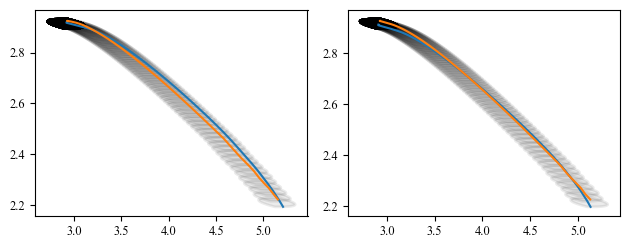

In [19]:
plt.figure()

step = 1  # increase for speed
max_tubes = 200

def plot_tube_for_model(model_name):
    data = results.get(model_name)
    if data is None:
        return
    x = data['x']
    enter = data['enter']
    z_nom = data['z_nom']
    
    if enter is None or z_nom.size == 0:
        return
    
    centers_actual = np.column_stack([x[0, enter:], x[3, enter:]])
    centers_nom = np.column_stack([z_nom[:, 0] + Ceq, z_nom[:, 1] + Ceq])
    
    plt.plot(centers_actual[:, 0], centers_actual[:, 1])
    plt.plot(centers_nom[:, 0], centers_nom[:, 1])
    
    tube_count = min(max_tubes, centers_nom.shape[0])
    for c in centers_nom[:tube_count:step]:
        so.plot_poly(approx_min_RPI, offset=c, color="k", alpha=0.08)

# Left: model 1
plt.subplot(2, 2, 1)
if len(model_names) >= 1:
    plot_tube_for_model(model_names[0])

# Right: model 2
plt.subplot(2, 2, 2)
if len(model_names) >= 2:
    plot_tube_for_model(model_names[1])

plt.tight_layout()
plt.savefig('tubes.pdf', bbox_inches='tight')

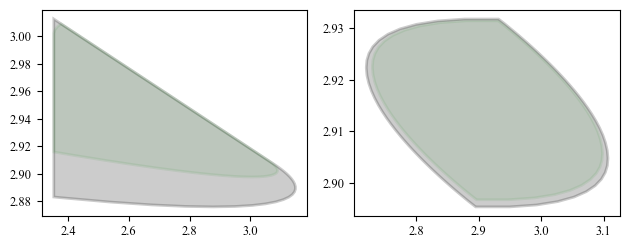

In [23]:
plt.subplot(2, 2, 1)
so.plot_poly(max_RPI, offset=C50, color='k')
so.plot_poly(max_RPI_lbd, offset=C50, color='g', alpha=0.08)
plt.subplot(2, 2, 2)
so.plot_poly(approx_min_RPI, offset=C50, color='k')
so.plot_poly(min_RPI, offset=C50, color='g', alpha=0.08)
plt.tight_layout()
plt.savefig('invariant_sets.pdf', bbox_inches='tight')